# Feature Engineering

* [1. Categorical variables](#1)
    * [1.1 Datetime to numerical conversion](#1.1)
    * [1.2 Strings](#1.2)
        * [1.2.1 City name column](#1.2.1)
        * [1.2.2 One-Hot or Label Encoder?](#1.2.2)
* [2.Numerical variables](#2)
    * [2.1 Floats](#2.1)
    * [2.2 Integers](#2.2)
* [3. Summary](#3)


In this notebook we'll prepare the data for the final modeling phase.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl # colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
import pickle

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0.02
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True

pd.set_option('max_columns', None) 
#pd.reset_option(“max_columns”)
#pd.set_option('mode.chained_assignment', None)
#pd.options.mode.chained_assignment = None
#

#common for all
y = pd.read_csv("./data/work_target.csv",index_col='ID',low_memory=False)
y.shape

(145231, 1)

## 1. Categorical variables<a id='1'></a>

### 1.1 Datetime to numerical conversion<a id='1.1'></a>

In [2]:
dft = pd.read_csv("./data/work_datetimes.csv",index_col='ID',low_memory=False)
dpt = pd.read_csv("./data/pred_datetimes.csv",index_col='ID',low_memory=False)

for col in dft.columns:
    dft[col] = pd.to_datetime(dft[col],format='%d%b%y:%H:%M:%S')
    dpt[col] = pd.to_datetime(dpt[col],format='%d%b%y:%H:%M:%S')
    
dft.shape,dpt.shape

((145231, 16), (145232, 16))

For datetime data everything is straighforward. We remove column 204, convert dates to the time difference w.r.t. to the earliest date in each column. For columns with high number of missing values, we also count row-wise the multiplicity of the non-zero entries, to account for possible correlations between them. Finally, we replace the missing values by -1:

In [3]:
# remove column 204
dft_fe = dft.drop('VAR_0204',axis=1)
dpt_fe = dpt.drop('VAR_0204',axis=1)

# convert to floats as a time difference w.r.t. to the column's lowest value (in day units)
for col in dft_fe.columns:
    
    dft_fe[col] = (dft_fe[col] - dft_fe[col].min())/np.timedelta64(1,'D')
    dpt_fe[col] = (dpt_fe[col] - dpt_fe[col].min())/np.timedelta64(1,'D')

# non-NaNs summation over rows in columns with large number of missing values
cols = sorted(set(dft_fe.columns) - set(['VAR_0075','VAR_0217']))
dft_fe['T_n'] = dft_fe[cols].notna().sum(axis=1)
dpt_fe['T_n'] = dpt_fe[cols].notna().sum(axis=1)

#replace NaNs with -1
dft_fe = dft_fe.fillna(-1)
dpt_fe = dpt_fe.fillna(-1)

# rename VAR_ -> T_, to keep track 
dft_fe.columns = dft_fe.columns.str.replace('VAR',"T")
dpt_fe.columns = dpt_fe.columns.str.replace('VAR',"T")

dft_fe.shape,dpt_fe.shape

((145231, 16), (145232, 16))

In [4]:
dft_fe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145231 entries, 2 to 290463
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   T_0073  145231 non-null  float64
 1   T_0075  145231 non-null  float64
 2   T_0156  145231 non-null  float64
 3   T_0157  145231 non-null  float64
 4   T_0158  145231 non-null  float64
 5   T_0159  145231 non-null  float64
 6   T_0166  145231 non-null  float64
 7   T_0167  145231 non-null  float64
 8   T_0168  145231 non-null  float64
 9   T_0169  145231 non-null  float64
 10  T_0176  145231 non-null  float64
 11  T_0177  145231 non-null  float64
 12  T_0178  145231 non-null  float64
 13  T_0179  145231 non-null  float64
 14  T_0217  145231 non-null  float64
 15  T_n     145231 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 18.8 MB


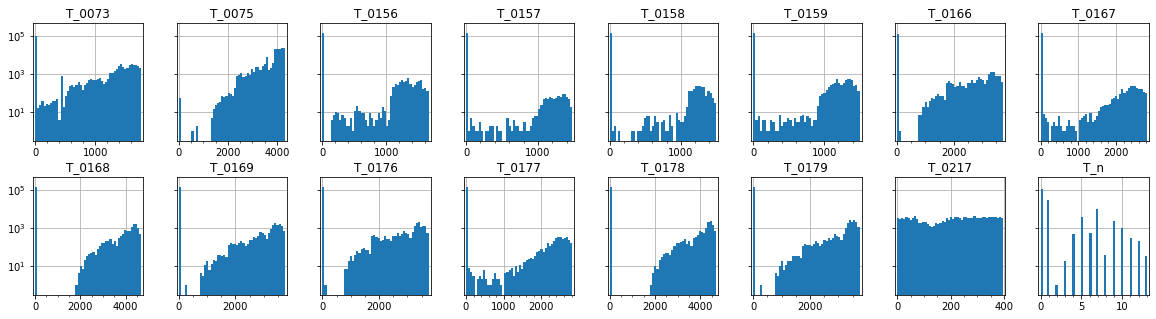

In [5]:
dft_fe.hist(layout=(2,8),figsize=(20,5),bins=50,log=True,sharey=True);

All done, looking good. Let's move on.

## 1.2 String to numerical conversion<a id='1.2'></a>

In [6]:
dfc = pd.read_csv("./data/work_strings.csv",index_col='ID',low_memory=False)
dpc = pd.read_csv("./data/pred_strings.csv",index_col='ID',low_memory=False)
 
dfc.shape,dpc.shape

((145231, 17), (145232, 17))

For string variables, we remove two columns with professions, convert he second column with the state information into binary information whether the state name is the same or different from the first state columns. We also count row-wise the miltuplicity of letters F-U and O-U in other six columns:

In [7]:
# remove columns 404 and 493 with profession names
dfc_fe = dfc.drop(['VAR_0404','VAR_0493'],axis=1)
dpc_fe = dpc.drop(['VAR_0404','VAR_0493'],axis=1)

# state codes: new column with 0/1 when 227 !=/== 274 
dfc_fe['C_state2'] = np.where(dfc_fe['VAR_0237'] == dfc_fe['VAR_0274'],1,0)
dpc_fe['C_state2'] = np.where(dpc_fe['VAR_0237'] == dpc_fe['VAR_0274'],1,0)

# and remove 274
dfc_fe = dfc_fe.drop(['VAR_0274'],axis=1)
dpc_fe = dpc_fe.drop(['VAR_0274'],axis=1)

# multiplicity of F-U codes per row (NaNs have no variations so skip them)
cols = ['VAR_0283','VAR_0305','VAR_0325']
codes = []; [codes.append(x) for col in cols for x in dfc[col].unique().tolist() if x is not np.nan]
codes = sorted(set(codes))

for code in codes:
    dfc_fe['C_n1_' + code] = (dfc[cols] == code).sum(axis=1)
    dpc_fe['C_n1_' + code] = (dpc[cols] == code).sum(axis=1)

# multiplicity of 0-U codes per row, skip nans 
cols = ['VAR_0352','VAR_0353','VAR_0354']
codes = []; [codes.append(x) for col in cols for x in dfc[col].unique().tolist() if x is not np.nan]
codes = sorted(set(codes))

for code in codes:
    dfc_fe['C_n2_' + code] = (dfc[cols] == code).sum(axis=1)
    dpc_fe['C_n2_' + code] = (dpc[cols] == code).sum(axis=1)

# rename VAR_ -> C_, to keep track 
dfc_fe.columns = dfc_fe.columns.str.replace('VAR',"C")
dpc_fe.columns = dpc_fe.columns.str.replace('VAR',"C")
    
dfc_fe.shape,dpc_fe.shape

((145231, 28), (145232, 28))

OK, done. Let's print a few rows and see where we are:

In [8]:
dfc_fe

,C_0001,C_0005,C_0200,C_0237,C_0283,C_0305,C_0325,C_0342,C_0352,C_0353,C_0354,C_0466,C_0467,C_1934,C_state2,C_n1_-1,C_n1_F,C_n1_G,C_n1_H,C_n1_M,C_n1_P,C_n1_R,C_n1_S,C_n1_U,C_n2_-1,C_n2_O,C_n2_R,C_n2_U
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,H,C,FT LAUDERDALE,FL,S,S,-1,CF,O,U,O,-1,-1,IAPS,1,1,0,0,0,0,0,0,2,0,0,2,0,1
4,H,B,SANTEE,CA,S,S,H,EC,O,R,R,I,Discharged,IAPS,0,0,0,0,1,0,0,0,2,0,0,1,2,0
5,H,C,REEDSVILLE,WV,S,P,R,UU,R,R,-1,-1,-1,IAPS,1,0,0,0,0,0,1,1,1,0,1,0,2,0
7,H,C,LIBERTY,TX,S,P,H,-1,R,R,-1,-1,-1,RCC,1,0,0,0,1,0,1,0,1,0,1,0,2,0
8,R,N,FRANKFORT,IL,S,P,S,-1,R,U,O,-1,-1,BRANCH,1,0,0,0,0,0,1,0,2,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290457,H,C,LAFAYETTE,LA,S,H,S,-1,R,U,R,-1,-1,BRANCH,1,0,0,0,1,0,0,0,2,0,0,0,2,1
290458,R,C,GARDENA,CA,H,H,S,BE,R,U,R,I,Discharged,IAPS,1,0,0,0,2,0,0,0,1,0,0,0,2,1
290459,R,B,COVINA,CA,S,S,P,CC,U,R,-1,-1,-1,BRANCH,1,0,0,0,0,0,1,0,2,0,1,0,1,1


Two things still to be done: (i) convert the city name column to numerical data with population information, (ii) convert the remaining 13 categorical variables using either one-hot and label encoding. 

#### 1.2.1 City name column <a id='1.2.1'></a>

Let's start with the city name column (C_0200). Let's load the reduced census database, which we prepared earlier:

In [9]:
db = pd.read_csv('data/cities_reduced.csv',index_col=0)

In [10]:
db.convert_dtypes().dtypes

city_ascii      string
state_id        string
population       Int64
density        float64
zips            string
county_fips      Int64
dtype: object

In [11]:
db.head()

,city_ascii,state_id,population,density,zips,county_fips
0,New York,NY,18713220,10715.0,11229 11226 11225 11224 11222 11221 11220 1138...,36061
1,Los Angeles,CA,12750807,3276.0,90291 90293 90292 91316 91311 90037 90031 9000...,6037
2,Chicago,IL,8604203,4574.0,60018 60649 60641 60640 60643 60642 60645 6064...,17031
3,Miami,FL,6445545,5019.0,33129 33125 33126 33127 33128 33149 33144 3314...,12086
4,Dallas,TX,5743938,1526.0,75287 75098 75233 75254 75251 75252 75253 7503...,48113


and match city names and states in both tables, then extract the population size. The population denisity is available as well, so we will include this variable too. But how should we match the entries? 

When comparing the exact city name in our data with those in the census database we succesfully matched 90% of the rows (not shown here). The remaning rows were not matched because of some common differences in the notation (e.g. SANTA/SAN vs ST., MOUNT vs MT., HIGH vs H. etc), abbreviations (e.g. CHGO vs CHICAGO, CINTI vs CINCINNATI, SLC vs SALT LAKE CITY) or spelling mistakes (e.g. TYLER vs TAYLOR, DUNMORE vs ANMOORE, PECKVILLE vs PARKVILLE). To correct for these we could use some NLP algorithms that evaluate the similarity between words, e.g. using the Levenshtein distance included in the FuzzyWuzzy package, or the Soundex package. But this would require some additional studies. 

Instead we will match by the zip code that is also provided in the census data. As our dataset includes the city and state information, it must also include the zip code. Let's try to find it. Zip codes are 5-digit numbers, for some states like NJ, CT etc. they start with a zero, so effectively they consist of 4 significant digits. Let's load in the integer dataset and look for the column that matches this syntax:

In [12]:
dfi = pd.read_csv("./data/work_integers.csv",index_col='ID',low_memory=False)
dpi = pd.read_csv("./data/pred_integers.csv",index_col='ID',low_memory=False)

In [13]:
dfi_max = dfi.max()
cols = dfi_max[(dfi_max >= 10000) & (dfi_max < 100000)].index
print(len(cols),'columns with max number of O(10^5).')

dfi_min = dfi[cols].min()
cols2 = dfi_min[(dfi_min >= 1000) & (dfi_min < 10000)].index
print(len(cols2),'columns with min number of O(10^4):',cols2.values)

14 columns with max number of O(10^5).
1 columns with min number of O(10^4): ['VAR_0241']


Ha! It was easier than we thought! Just one column in our entire dataset fulfills these conditions. 

So let's do the matching now. Let's prepare a function that will first try to match the entries by the zip code, and then, for the remaining part, match the exact city name (see this [additional notebook](./matching_2DFs.ipynb), where we optimize the algorithm against the execution time): 

In [14]:
def city_to_population():
    
    # prepare subsamples of db, dictionaries with key = state_id 
    dbs = dict()
    
    sid = db['state_id'].unique()

    for id in sid:
        dbs[id] = db[db['state_id'] == id]   
    
    # do the matching
    for i, (c,s,z) in enumerate(df.values):  
        
        if s != s or z != z:
            continue
            
        z = str(int(z))
       
        # first by zip
        db_matched = dbs[s][dbs[s]['zips'].str.contains(z)]
    
        if not db_matched.empty:

            n[i] = db_matched['population'].values[0]
            d[i] = db_matched['density'].values[0]
    
        else:
            
            #then by city
            if n[i] == 0:
                
                db_matched = dbs[s][dbs[s]['city_ascii'].str.upper() == c]
                                 
                if not db_matched.empty:
            
                    n[i] = db_matched['population'].values[0]
                    d[i] = db_matched['density'].values[0]
                
                else:
                
                    logs.append((i,c,s))

Let's run in on the data (and also save the output lists with the city population and density into pickle files):

In [15]:
from_file =  False
# from_file =  True
# ------------------

t1 = dt.now()

#global df, n, d, logs

n = [0] * (dfc.shape[0] + dpc.shape[0])
d = [0] * (dfc.shape[0] + dpc.shape[0])

logs = []

if from_file:  

    with open('./data/population.pkl', 'rb') as f:   n = pickle.load(f)
    with open('./data/density.pkl', 'rb') as f:   d = pickle.load(f)
    with open('./data/logs.pkl', 'rb') as f:   logs = pickle.load(f)
        
else:

    # stack *work* and *pred* datasets on top of each other
    dc = pd.concat((dfc[['VAR_0200','VAR_0237']],dpc[['VAR_0200','VAR_0237']]))
    di = pd.concat((dfi['VAR_0241'],dpi['VAR_0241']))
    
    # merge the city, state with the zip info
    df = pd.concat((dc,di),axis=1)
    
    city_to_population()
 
    # save to files
    with open('./data/population.pkl', 'wb') as f:   pickle.dump(n, f)
    with open('./data/density.pkl', 'wb') as f:   pickle.dump(d, f)
    with open('./data/logs.pkl', 'wb') as f:   pickle.dump(logs, f)

#separate the *work* and *pred* samples
n1 = n[:dfc.shape[0]]; n2 = n[dfc.shape[0]:]
d1 = d[:dfc.shape[0]]; d2 = d[dfc.shape[0]:]

t2 = dt.now()

print(round((t2-t1).total_seconds()/60,1),'min elapsed,',\
      '{} ({}%) matched'.format( sum(np.array(n)>0), round(sum(np.array(n)>0)/len(n)*100),1))  

5.1 min elapsed, 283038 (97.0%) matched


Nice, 97% matched. What's in the remaining 3%?:

In [16]:
logs[:5]

[(16, 'SHELBY GAP', 'KY'),
 (48, 'COLUMBIA STATION', 'OH'),
 (129, 'MAUK', 'GA'),
 (161, 'CARTERSVILLE', 'VA'),
 (184, 'CHAPPELLS', 'SC')]

According to Wiki, these are unincorporated locations with no info on the population size. Probably that's the reason why they are not included in the census database. OK, let's stop here and go ahead with zeros as the population and density enries for these locations.

Let's go back to out dataset and create columns with the new info:

In [17]:
dfc_fe['C_pop'] = n1; dfc_fe['C_den'] = d1
dpc_fe['C_pop'] = n2; dpc_fe['C_den'] = d2

# and remove 200
dfc_fe = dfc_fe.drop(['C_0200'],axis=1)
dpc_fe = dpc_fe.drop(['C_0200'],axis=1)

What did we gain by this data conversion? Let's plot the distributions of the city population and density and also the average target response:

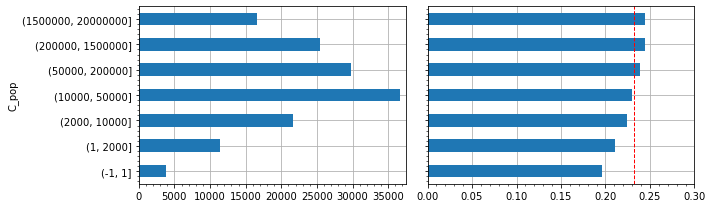

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,3),sharey=True)

df = pd.concat((dfc_fe['C_pop'],y),axis=1)

bins = pd.cut(df['C_pop'], [-1, 1,2_000,10_000,50_000,200_000,1_500_000,20_000_000])

df.groupby(bins)['target'].count().plot.barh(ax=ax[0],legend=None)
df.groupby(bins)['target'].mean().plot.barh(ax=ax[1],legend=None)

ax[1].set_xlim(right = 0.3) 
ax[1].axvline(df['target'].mean(),linewidth=1,linestyle='--',color='r');

fig.tight_layout()

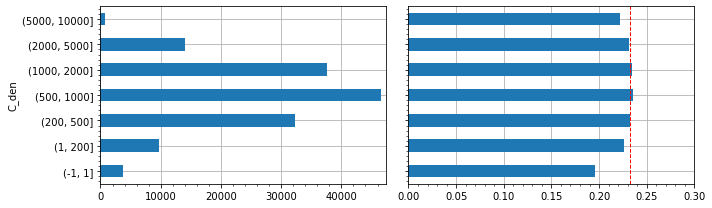

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,3),sharey=True)

df = pd.concat((dfc_fe['C_den'],y),axis=1)

bins = pd.cut(df['C_den'], [-1, 1,200,500,1_000,2_000,5_000,10_000])

df.groupby(bins)['target'].count().plot.barh(ax=ax[0],legend=None)
df.groupby(bins)['target'].mean().plot.barh(ax=ax[1],legend=None)
ax[1].set_xlim(right = 0.3) 
ax[1].axvline(df['target'].mean(),linewidth=1,linestyle='--',color='r');

fig.tight_layout()

Hmmm, a lot of work and a little gain. Surprisingly, the average target response does not depend stongly on those variables. We do see that customers from smaller cities tend to respond less to the offer, while those from large cities resond more. But this is a 3% effect in bins that have little data. The density variables seems to be even less sensitive. Nevertheless, we will keep those newly created variables in.

####  1.2.2 One-Hot or Label Encoder? <a id='1.2.2'></a>

Not it's time to convert the remaning categorical variables to numbers. But which transformation method should we use? One-hot encoding or label encoding? And for the label encoding, is the alphanumerical ordering, which comes as a default with the LabelEncoder function, sufficient or perhaps we'd better off with ordering by the increasing target response (see Sec. 1 point 4 of the previous notebook)? Let's the data tell us. Let's select the columns of interest and transform them using the 3 different methods, then let's run a few simple classifiers to see which method provides the best results.

In [20]:
cols_cat = [c for c in dfc_fe.columns if c.split('_')[1].isnumeric()]

dfc_fe[cols_cat]

,C_0001,C_0005,C_0237,C_0283,C_0305,C_0325,C_0342,C_0352,C_0353,C_0354,C_0466,C_0467,C_1934
ID,,,,,,,,,,,,,
2,H,C,FL,S,S,-1,CF,O,U,O,-1,-1,IAPS
4,H,B,CA,S,S,H,EC,O,R,R,I,Discharged,IAPS
5,H,C,WV,S,P,R,UU,R,R,-1,-1,-1,IAPS
7,H,C,TX,S,P,H,-1,R,R,-1,-1,-1,RCC
8,R,N,IL,S,P,S,-1,R,U,O,-1,-1,BRANCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290457,H,C,LA,S,H,S,-1,R,U,R,-1,-1,BRANCH
290458,R,C,CA,H,H,S,BE,R,U,R,I,Discharged,IAPS
290459,R,B,CA,S,S,P,CC,U,R,-1,-1,-1,BRANCH


1) one-hot (oh) conversion:

In [21]:
# combine work+pred (to avoid possible issues with missing labels), do dummy, then separate 
df = pd.concat((dfc_fe[cols_cat],dpc_fe[cols_cat]))
nrows = dfc_fe.shape[0]

df_oh = df.fillna('nan')

df_oh = pd.get_dummies(df_oh, prefix=df_oh.columns)

dfc_oh = df_oh[:nrows]
dpc_oh = df_oh[nrows:]

print(dfc_fe[cols_cat].shape,dfc_oh.shape)
#print(dpc_fe[cols_cat].shape,dpc_oh.shape)

dfc_oh.head()

(145231, 13) (145231, 161)


,C_0001_H,C_0001_Q,C_0001_R,C_0005_B,C_0005_C,C_0005_N,C_0005_S,C_0237_AK,C_0237_AL,C_0237_AR,C_0237_AZ,C_0237_CA,C_0237_CO,C_0237_CT,C_0237_DC,C_0237_DE,C_0237_FL,C_0237_GA,C_0237_HI,C_0237_IA,C_0237_ID,C_0237_IL,C_0237_IN,C_0237_KS,C_0237_KY,C_0237_LA,C_0237_MD,C_0237_MI,C_0237_MN,C_0237_MO,C_0237_MS,C_0237_MT,C_0237_NC,C_0237_ND,C_0237_NE,C_0237_NJ,C_0237_NM,C_0237_NV,C_0237_NY,C_0237_OH,C_0237_OK,C_0237_OR,C_0237_PA,C_0237_SC,C_0237_SD,C_0237_TN,C_0237_TX,C_0237_UT,C_0237_VA,C_0237_WA,C_0237_WI,C_0237_WV,C_0237_WY,C_0237_nan,C_0283_-1,C_0283_F,C_0283_G,C_0283_H,C_0283_P,C_0283_R,C_0283_S,C_0283_U,C_0283_nan,C_0305_-1,C_0305_F,C_0305_H,C_0305_M,C_0305_P,C_0305_R,C_0305_S,C_0305_U,C_0305_nan,C_0325_-1,C_0325_F,C_0325_G,C_0325_H,C_0325_M,C_0325_P,C_0325_R,C_0325_S,C_0325_U,C_0325_nan,C_0342_-1,C_0342_AA,C_0342_AB,C_0342_AC,C_0342_AD,C_0342_AE,C_0342_AF,C_0342_AU,C_0342_BA,C_0342_BB,C_0342_BC,C_0342_BD,C_0342_BE,C_0342_BF,C_0342_BU,C_0342_CA,C_0342_CB,C_0342_CC,C_0342_CD,C_0342_CE,C_0342_CF,C_0342_CU,C_0342_DA,C_0342_DB,C_0342_DC,C_0342_DD,C_0342_DE,C_0342_DF,C_0342_DU,C_0342_EA,C_0342_EB,C_0342_EC,C_0342_ED,C_0342_EE,C_0342_EF,C_0342_EU,C_0342_FA,C_0342_FB,C_0342_FC,C_0342_FD,C_0342_FE,C_0342_FF,C_0342_FU,C_0342_UA,C_0342_UB,C_0342_UC,C_0342_UD,C_0342_UE,C_0342_UF,C_0342_UU,C_0342_nan,C_0352_-1,C_0352_O,C_0352_R,C_0352_U,C_0352_nan,C_0353_-1,C_0353_O,C_0353_R,C_0353_U,C_0353_nan,C_0354_-1,C_0354_O,C_0354_R,C_0354_U,C_0354_nan,C_0466_-1,C_0466_I,C_0466_nan,C_0467_-1,C_0467_Discharge NA,C_0467_Discharged,C_0467_Dismissed,C_0467_nan,C_1934_BRANCH,C_1934_CSC,C_1934_IAPS,C_1934_MOBILE,C_1934_RCC
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
7,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
8,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0


2) default label encoding (le)

In [22]:
from sklearn.preprocessing import LabelEncoder

df_le = df.fillna('nan')

for col in cols_cat:
    
    le = LabelEncoder()

    df_le[col] = le.fit_transform(df_le[col].values)
    
dfc_le = df_le[:nrows]
dpc_le = df_le[nrows:]
    
print(dfc_fe[cols_cat].shape,dfc_le.shape)
#print(dpc_fe[cols_cat].shape,dpc_le.shape)

dfc_le.head()

(145231, 13) (145231, 13)


,C_0001,C_0005,C_0237,C_0283,C_0305,C_0325,C_0342,C_0352,C_0353,C_0354,C_0466,C_0467,C_1934
ID,,,,,,,,,,,,,
2,0,1,9,6,6,0,20,1,3,1,0,0,2
4,0,0,4,6,6,3,31,1,2,2,1,2,2
5,0,1,44,6,4,6,49,2,2,0,0,0,2
7,0,1,39,6,4,3,0,2,2,0,0,0,4
8,2,2,14,6,4,7,0,2,3,1,0,0,0


3) label encoding with labels ordered by increasing average target response (lo):

In [23]:
dfc_lo = dfc_fe[cols_cat].fillna('nan')
dpc_lo = dpc_fe[cols_cat].fillna('nan')

for col in dfc_lo.columns:
    
    dfy = pd.concat((dfc_lo[col].astype('str'),y),axis=1)

    #order each label by increasing y mean, reset index and convert to a dict(label,index)
    s = dfy.groupby(col).mean().sort_values(by='target')['target'].reset_index()
    label_to_int = {label : num_code for label, num_code in zip(s[col],s.index)}
    
    #print(col,label_to_int)
    
    dfc_lo[col] = dfc_lo[col].map(label_to_int)
    dpc_lo[col] = dpc_lo[col].map(label_to_int)

print(dfc_fe[cols_cat].shape,dfc_lo.shape)

dfc_lo.head()

(145231, 13) (145231, 13)


,C_0001,C_0005,C_0237,C_0283,C_0305,C_0325,C_0342,C_0352,C_0353,C_0354,C_0466,C_0467,C_1934
ID,,,,,,,,,,,,,
2,0,1,21,2,3,3,36,0,4,0,0,0,3
4,0,0,23,2,3,7,13,0,3,1,2,2,3
5,0,1,3,2,2,0,34,3,3,4,0,0,3
7,0,1,29,2,2,7,35,3,3,4,0,0,2
8,2,3,24,2,2,6,35,3,4,0,0,0,1


(was the *lo* conversion successful also for the *pred* dataset? does it still have any non-numerical columns after the transformation?:

In [24]:
dpc_lo.select_dtypes(exclude=['int','float']).columns

Index([], dtype='object')

none, all is good.)

Which method perform best? Let's run the Decision Tree and Logistic Regression classifiers on these 3 samples: 

In [25]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,classification_report

In [26]:
def evaluate_scores(Xs,model='DT'):
    
    for i,X in enumerate(Xs):
    
        X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.25, random_state=123)

        m = 0
        if model == 'DT':
            
            m = DecisionTreeClassifier(random_state=123)
            
        elif model == 'RF':
            
            m = RandomForestClassifier(random_state=123)
            
        else:
            
            m = LogisticRegression(max_iter=1000,random_state=123)
            
            sc = StandardScaler()    
            X_train, X_test = sc.fit_transform(X_train), sc.transform(X_test)
        
        m.fit(X_train,y_train)
        y_pred = m.predict(X_test)
        
        print_scores(model,i,y_test,y_pred)

def print_scores(mod,data,y_test,y_pred):
    
    print('{}) {}:'.format(data,mod),'roc_auc/accuracy/precision/recall score ='
          ,round(roc_auc_score(y_test, y_pred),2)
          ,'/',round(accuracy_score(y_test, y_pred),2)
          ,'/',np.around(precision_score(y_test, y_pred,labels=[0,1],average=None),2)
          ,'/',np.around(recall_score(y_test, y_pred,labels=[0,1],average=None),3)
         )

In [27]:
evaluate_scores([dfc_oh,dfc_le,dfc_lo])

0) DT: roc_auc/accuracy/precision/recall score = 0.53 / 0.7 / [0.78 0.29] / [0.846 0.208]
1) DT: roc_auc/accuracy/precision/recall score = 0.52 / 0.69 / [0.78 0.28] / [0.837 0.211]
2) DT: roc_auc/accuracy/precision/recall score = 0.53 / 0.69 / [0.78 0.29] / [0.836 0.218]


In [28]:
evaluate_scores([dfc_oh,dfc_le,dfc_lo],'LR')

0) LR: roc_auc/accuracy/precision/recall score = 0.5 / 0.77 / [0.77 0.58] / [0.998 0.008]
1) LR: roc_auc/accuracy/precision/recall score = 0.5 / 0.77 / [0.77 0.42] / [0.999 0.002]
2) LR: roc_auc/accuracy/precision/recall score = 0.5 / 0.77 / [0.77 0.55] / [0.997 0.011]


The top 3 rows show the usual score results obtained with the Decision Tree (DT) classifier, while the bottom 3 rows are for Logistic Regression (LR). Clearly, the 13 used variables don't offer any good classification performance yet, but we're only interested in the relative scores. And what can we see? While the over all scores of the area under the ROC curve and the accuracy don't change, there are some differences in the precision and recall. For both DT and LR the best recall for class 1 (responding customers) can be seen in the last row, for label encoding with the ordering by the average target response (lo), although the differences are really small. Given the fact that one-hot encoding would increase the number of variables from 13 to 161, while label encoding will keep the original 13 columns, we're selecting the last method for the rest of the analysis. 

Let's prepare the final dataset with all the converted categorical columns and move on:

In [29]:
dfc_ready = pd.concat((dfc_lo, dfc_fe.drop(cols_cat,axis=1),dft_fe),axis=1)
dpc_ready = pd.concat((dpc_lo, dpc_fe.drop(cols_cat,axis=1),dpt_fe),axis=1)

dfc_ready.shape

(145231, 45)

In [30]:
dfc_ready.head()

,C_0001,C_0005,C_0237,C_0283,C_0305,C_0325,C_0342,C_0352,C_0353,C_0354,C_0466,C_0467,C_1934,C_state2,C_n1_-1,C_n1_F,C_n1_G,C_n1_H,C_n1_M,C_n1_P,C_n1_R,C_n1_S,C_n1_U,C_n2_-1,C_n2_O,C_n2_R,C_n2_U,C_pop,C_den,T_0073,T_0075,T_0156,T_0157,T_0158,T_0159,T_0166,T_0167,T_0168,T_0169,T_0176,T_0177,T_0178,T_0179,T_0217,T_n
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,1,21,2,3,3,36,0,4,0,0,0,3,1,1,0,0,0,0,0,0,2,0,0,2,0,1,106306,1175.0,-1.0,3963.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,37.0,0
4,0,0,23,2,3,7,13,0,3,1,2,2,3,0,0,0,0,1,0,0,0,2,0,0,1,2,0,3220118,1686.0,1707.0,3965.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,366.0,1
5,0,1,3,2,2,0,34,3,3,4,0,0,3,1,0,0,0,0,0,1,1,1,0,1,0,2,0,604,359.0,-1.0,3998.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,72.0,0
7,0,1,29,2,2,7,35,3,3,4,0,0,2,1,0,0,0,1,0,1,0,1,0,1,0,2,0,6435,80.0,-1.0,3552.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,396.0,0
8,2,3,24,2,2,6,35,3,4,0,0,0,1,1,0,0,0,0,0,1,0,2,0,0,1,1,1,19448,807.0,-1.0,3939.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,13.0,0


## 2. Numerical variables<a id='2'></a>

### 2.1 Floats<a id='2.1'></a>

We only need to replace NaNs with a number here. The average target response is slightly different for the rows with NaNs and with -1, so we will replace them with -2:

In [31]:
dff = pd.read_csv("./data/work_floats.csv",index_col='ID',low_memory=False).convert_dtypes()
dpf = pd.read_csv("./data/pred_floats.csv",index_col='ID',low_memory=False).convert_dtypes()

dff = dff.fillna(-2)
dpf = dpf.fillna(-2)

dff.shape, dpf.shape

((145231, 10), (145232, 10))

In [32]:
dff.isna().sum(axis=0)

VAR_0299    0
VAR_0300    0
VAR_0301    0
VAR_0319    0
VAR_0320    0
VAR_0321    0
VAR_0335    0
VAR_0336    0
VAR_0337    0
VAR_0370    0
dtype: int64

Done.

### 2.2 Integers<a id='2.2'></a>

In [33]:
dfi = pd.read_csv("./data/work_integers.csv",index_col='ID',low_memory=False).convert_dtypes()
dpi = pd.read_csv("./data/pred_integers.csv",index_col='ID',low_memory=False).convert_dtypes()

dfi.shape,dpi.shape

((145231, 1837), (145232, 1837))

In the integer data there numerous columns with repeating minimal negative numbers, -1 and -9999, and repeating maximal positive numbers: 99, 999, 9999 and 9999999999. Let's separate them again:

In [34]:
dfi_min = dfi.min()

cols_a = dfi_min[dfi_min == -1].index
cols_b = dfi_min[dfi_min == -99999].index

print(len(cols_a),'columns with -1')
print(len(cols_b),'columns with -99999')

104 columns with -1
156 columns with -99999


Only those with -1 contain also a small admixture of NaNs, which we will replace with -2. This is because the average target response for rows with NaNs is slightly different than for the rows with -1.

In [35]:
dfi_a = dfi[cols_a].fillna(-2)
dpi_a = dpi[cols_a].fillna(-2)

OK, -1's done. 

Let's move to the subsample with -99999. In principle, we could leave it unchanged, but let's test how the models perform if we replace -99999 by -1. Let's create samples with and without replacement:

In [36]:
dfi_b = dfi[cols_b]
dpi_b = dpi[cols_b]

dfi_b_narrow = dfi_b.replace(-99999,-1)
dpi_b_narrow = dpi_b.replace(-99999,-1)

In [37]:
#dfi_a.columns = dfi_a.columns.str.replace('VAR_','I1_')
#dfi_b.columns = dfi_b.columns.str.replace('VAR_','I2_')

#cm = pd.concat((dfi_a,dfi_b),axis=1).corr()

do some printing for selected columns (notice a big change in the mean):

In [38]:
dfi_b.describe().iloc[1:,5:14]

,VAR_0707,VAR_0708,VAR_0709,VAR_0710,VAR_0711,VAR_0712,VAR_0713,VAR_0714,VAR_0715
mean,58.101996,-2253.044020,-17902.438736,-87063.817105,-33539.145589,-2250.076650,-17901.521177,-87063.769739,-33538.572598
std,788.278756,14853.626675,38338.832926,33558.901801,47213.451141,14854.078565,38339.261468,33559.024687,47213.858217
min,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000
25%,43.000000,1.000000,0.000000,-99999.000000,-99999.000000,2.000000,0.000000,-99999.000000,-99999.000000
50%,64.000000,3.000000,1.000000,-99999.000000,0.000000,5.000000,1.000000,-99999.000000,1.000000
75%,84.000000,5.000000,2.000000,-99999.000000,1.000000,9.000000,3.000000,-99999.000000,2.000000
max,335.000000,93.000000,49.000000,15.000000,34.000000,127.000000,80.000000,21.000000,47.000000


In [39]:
dfi_b_narrow.describe().iloc[1:,5:14]

,VAR_0707,VAR_0708,VAR_0709,VAR_0710,VAR_0711,VAR_0712,VAR_0713,VAR_0714,VAR_0715
mean,64.298896,4.004710,1.094229,-0.813270,0.543445,6.972079,2.011788,-0.765904,1.116435
std,30.505871,4.962579,2.058491,0.540968,1.753924,7.358433,2.951822,0.677163,2.471602
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,43.000000,1.000000,0.000000,-1.000000,-1.000000,2.000000,0.000000,-1.000000,-1.000000
50%,64.000000,3.000000,1.000000,-1.000000,0.000000,5.000000,1.000000,-1.000000,1.000000
75%,84.000000,5.000000,2.000000,-1.000000,1.000000,9.000000,3.000000,-1.000000,2.000000
max,335.000000,93.000000,49.000000,15.000000,34.000000,127.000000,80.000000,21.000000,47.000000


and finally, let's run the Decision Tree (DT), Random Forest (RF) and Logistic Regression (LR) classifiers on them:

In [40]:
evaluate_scores([dfi_b,dfi_b_narrow])

0) DT: roc_auc/accuracy/precision/recall score = 0.57 / 0.69 / [0.8  0.33] / [0.788 0.353]
1) DT: roc_auc/accuracy/precision/recall score = 0.57 / 0.69 / [0.8  0.34] / [0.788 0.354]


In [41]:
evaluate_scores([dfi_b,dfi_b_narrow],'RF')

0) RF: roc_auc/accuracy/precision/recall score = 0.56 / 0.78 / [0.79 0.64] / [0.975 0.147]
1) RF: roc_auc/accuracy/precision/recall score = 0.56 / 0.78 / [0.79 0.64] / [0.975 0.148]


In [42]:
evaluate_scores([dfi_b,dfi_b_narrow],'LR')

/data/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0) LR: roc_auc/accuracy/precision/recall score = 0.51 / 0.77 / [0.77 0.52] / [0.993 0.025]
1) LR: roc_auc/accuracy/precision/recall score = 0.55 / 0.78 / [0.79 0.57] / [0.968 0.141]


One apartent observation is that while both samples show the same performance with the DT and RF models, the Linear Regression model fails with the original data. The gap in the spectra is so large that, eventhough we scaled the data before running LR, the model suggest to scale data again :-)

So, which sample to choose, with or without replacement? As in the next section we would like to run the LR model with the L1 penalty to reduce the dimensionality of our data (LASSO-like coefficient suppresion), we'll choose the option with replacement. Let's prepare the final dataset for this part of the data (negative mins): 

In [43]:
dfi_part1 = pd.concat((dfi_a,dfi_b_narrow),axis=1)
dpi_part1 = pd.concat((dpi_a,dpi_b_narrow),axis=1)

OK.

***

Now moving to the large positive numbers. Here the situation is complicated as we have multiple entries with values outside of range.

Let's separate them again:

In [44]:
dfi_max = dfi.max()

limits = [99, 999, 9999, 999999999]

cols9 = []; dfi9 = []
for i, limit in enumerate(limits):
    
    cols9.append(dfi_max[dfi_max == limit].index)
    print(len(cols9[i]),'columns with max =',limit)
    
    dfi9.append( dfi[cols9[i]][dfi[cols9[i]] < limit])

458 columns with max = 99
238 columns with max = 999
159 columns with max = 9999
257 columns with max = 999999999


And let's recall plots in Sec. 1 of the [previous notebook](./exploratory_data_analysis.ipynb#1). We're expect a similar issue for LR performance, so we will shift the extremely high-value part of the spectra to small negative integers (-10 to -1). 

__To be done...__ 

For now, let's just write the whole dataset out as it is, at least DT and RF can work with no problems.

In [45]:
#just replace in the integer dataset the cols with -1 and -99999 that we already did.

for col in dfi_part1.columns:
    
    dfi[col] = dfi_part1[col]
    dpi[col] = dpi_part1[col]

Any missing values in the columns that don't have large negative or positive numbers?:

In [48]:
inans = dfi.isna().sum(axis=0)
inans[inans>0]

VAR_0006     56
VAR_0007     56
VAR_0008     56
VAR_0013     56
VAR_0014     56
           ... 
VAR_0511    918
VAR_0512    918
VAR_0526    917
VAR_0529    917
VAR_0531    917
Length: 331, dtype: int64

Yes, let's replace them with -1:

In [50]:
dfi = dfi.fillna(-1)
dpi = dpi.fillna(-1)

## 3. Summary<a id='3'></a>

As a final step we will merge both the categorical and numerical data into one final dataset:

In [52]:
df_final = pd.concat((dft_fe,dfc_ready,dff,dfi),axis=1)
dp_final = pd.concat((dpt_fe,dpc_ready,dpf,dpi),axis=1)

df_final.shape,dp_final.shape

((145231, 1908), (145232, 1908))

and write it down for the next step:

In [53]:
df_final.to_csv('data/work_final_4modeling.csv')
dp_final.to_csv('data/pred_final_4modeling.csv')

In [54]:
#! date
#! ls -lrth data/ | grep csv | grep final